# Loading libraries

In [1]:
import os
os.chdir('..')
from pathlib import Path
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict, Counter
import numpy as np
import pickle
import matplotlib
import hdbscan
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
from matplotlib.markers import MarkerStyle
from sklearn.metrics import silhouette_samples, silhouette_score
import plotly.express as px
from matplotlib.colors import ListedColormap
from itertools import groupby
from utils.structural_algorithms import MappedRegion
import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
terpene_synthases_df = pd.read_csv('data/TPS-Nov19_2023_verified_all_reactions_with_neg_with_folds.csv')

terpene_synthases_classes = pd.read_csv('data/TPS-reaction-mechanism-classes-cleaned.csv')
terpene_synthases_df = terpene_synthases_df.drop('Class (I or II)', axis=1).merge(terpene_synthases_classes[['Uniprot ID', 
                                                                                                             'Substrate (including stereochemistry)', 
                                                                                                             'Name of product', 
                                                                                                             'Class (I or II)']], on=['Uniprot ID', 'Substrate (including stereochemistry)', 'Name of product'])
terpene_synthases_df.loc[(terpene_synthases_df['Type (mono, sesq, di, …)'] == "di-int"), 'Type (mono, sesq, di, …)'] = 'di'
terpene_synthases_df.loc[(terpene_synthases_df['Type (mono, sesq, di, …)'] == "di") & 
                     (terpene_synthases_df['Class (I or II)'] == "prenyl"), 'Type (mono, sesq, di, …)'] = 'ggpps'

terpene_synthases_df.loc[terpene_synthases_df['Type (mono, sesq, di, …)'].isin({'ggpps', 'fpps', 'gpps', 'gfpps', 'hsqs'}), 'SMILES_substrate_canonical_no_stereo'] = 'precursor substr'
terpene_synthases_df.loc[terpene_synthases_df['Type (mono, sesq, di, …)'].isin({'ggpps', 'fpps', 'gpps', 'gfpps', 'hsqs'}), 'SMILES_product_canonical_no_stereo'] = 'precursors'
terpene_synthases_df.loc[terpene_synthases_df['Type (mono, sesq, di, …)'].isin({'ggpps', 'fpps', 'gpps', 'gfpps', 'hsqs'}), 'Type (mono, sesq, di, …)'] = 'polyprenyl synthetase'

terpene_synthases_df.loc[(terpene_synthases_df['Type (mono, sesq, di, …)'] == "polyprenyl synthetase") & 
                         (terpene_synthases_df['Class (I or II)'] == "Class I"), 'Type (mono, sesq, di, …)'] = 'hemi'

def get_reaction_type(tps_type, tps_class):
    if tps_type in {'tetra', 'tetra-int'}:
        return 'tetra'
    if tps_type in {'sester', 'sesquar', 'sesq', 'hemi', 'mono'}:
        return tps_type
    if tps_type == 'polyprenyl synthetase':
        return 'isoprenyl diphosphate synthase'
    if 'tri' in tps_type:
        if tps_class == 'prenyl':
            return f'tri (squalene synthase)'
        return f'tri ({tps_class})'
    if tps_type == 'di':
        return f'di ({tps_class})'
    return False
    
terpene_synthases_df['reaction_type'] = (terpene_synthases_df['Type (mono, sesq, di, …)'].map(lambda x: [x]) 
 + terpene_synthases_df['Class (I or II)'].map(lambda x: [x])).map(lambda x: get_reaction_type(*x))
terpene_synthases_df = terpene_synthases_df[terpene_synthases_df['reaction_type'] != False]

In [3]:
id_2_substrates_set = terpene_synthases_df.groupby('Uniprot ID')['SMILES_substrate_canonical_no_stereo'].agg(set)
id_2_type_set = terpene_synthases_df.groupby('Uniprot ID')['reaction_type'].agg(set)

In [4]:
def get_dist_mat_precomputed(regions: list[tuple[str, MappedRegion]], root_path: Path = Path(f'data/tps_domains_and_comparisons/'), 
                             selected_indices: np.ndarray = None) -> np.ndarray:
    dist_mat = np.ones((len(regions), len(regions)))
        
    for region_i, (filename, region) in tqdm(enumerate(regions), total=len(regions)):
        all_paths = list(root_path.glob(f'all_tm_region_very_conf_{region_i}_{region.module_id}.pkl'))
        assert len(all_paths) == 1, f'Precomputed path error for {region_i}/{region.module_id} [file {f"all_tm_region_very_conf_*_{region.module_id}.pkl"}]: # of results is {len(all_paths)} ({",".join(map(str, all_paths))})'
        with open(all_paths[0], 'rb') as f:
            distances_list = pickle.load(f)
        for i, j, dist in distances_list:
            dist_mat[i, j] = dist
            dist_mat[j, i] = dist
    if selected_indices is not None:
        orig_idx_2_new = {orig_i: i for i, orig_i in enumerate(selected_indices)}
        dist_mat_subset = -np.ones((len(selected_indices), len(selected_indices)))
        for i, row_idx in enumerate(selected_indices):
            for i_j_delta, col_idx in enumerate(selected_indices[i + 1:]):
                dist_mat[row_idx, col_idx]
                j = i + 1 + i_j_delta
                assert orig_idx_2_new[row_idx] == i and orig_idx_2_new[col_idx] == j
                dist_mat_subset[i, j] = dist
                dist_mat_subset[j, i] = dist
        return dist_mat_subset
    return dist_mat
    
with open(f"data/tps_domains_and_comparisons/regions_completed_very_confident_all_ALL.pkl", "rb") as f:
    regions = pickle.load(f)
    
dist_mat = get_dist_mat_precomputed(regions)

  0%|          | 0/2552 [00:00<?, ?it/s]

In [5]:
dist_mat = 1 - dist_mat
np.fill_diagonal(dist_mat, 0)

In [6]:
known_non_neg_bool_idx = np.array([(list(id_2_type_set[uni_id])[0] if uni_id in id_2_type_set and len(id_2_type_set[uni_id]) else '') not in {'Unknown', 'Negative', ''} for uni_id, _ in regions])
all_ids_list = [regions[i][0] for i in range(len(regions)) if known_non_neg_bool_idx[i]]
dist_mat = dist_mat[:, known_non_neg_bool_idx][known_non_neg_bool_idx]

In [7]:
regions = [regions[i] for i in range(len(regions)) if known_non_neg_bool_idx[i]]

In [8]:
reducer_pca = PCA(n_components=2, random_state=42)
pca_coord_dom = reducer_pca.fit_transform(dist_mat)

In [9]:
core_class_names = ['tetra',
 'sesquar',
 'tri (Class I)',
 'sester',
 'di (Class I)',
 'sesq',
 'mono',
 'isoprenyl diphosphate synthase',
 'hemi']

cmap = matplotlib.colormaps["tab20"]
colors = cmap(np.linspace(0, 1, 20))
reaction_class_2_color = {class_name: colors[2*i] for i, class_name in enumerate(core_class_names)}
reaction_class_2_color['di (Class II)'] = colors[9]
reaction_class_2_color['tri (Class II)'] = colors[5]

cmap2 = matplotlib.colormaps["Dark2"]
colors2 = cmap2(np.linspace(0, 1, 8))
reaction_class_2_color['tri (squalene synthase)'] = colors2[0]

In [10]:
def plot(all_ids_list, coord, title_str, file_name, id_2_substrates_set, double_domain_ids, domain_order=None, point_labels=None,
         is_jittered=True, jitter_param=0.005, dot_size=22, legend_anchor=(.3005, 0.), 
         classes_order=['tetra',
                         'sesquar',
                         'tri (Class I)',
                         'tri (Class II)',
                         'tri (squalene synthase)',
                         'sester',
                         'di (Class I)',
                         'di (Class II)',
                         'sesq',
                         'mono',
                         'hemi',
                         'isoprenyl diphosphate synthase'],
         reaction_class_2_color=reaction_class_2_color,
        no_interm_names=False, plot_size=(10, 10), legend_title='TPS Type', categories_to_show=None, color_double_domains_only=True,
        mark_double_alpha_points=False):

    coords = [coord[:, 0], coord[:, 1]]
    _, ax = plt.subplots(1, 1, figsize=plot_size)

    class_2_x = defaultdict(list)
    class_2_y = defaultdict(list)
    class_2_is_double_domain = defaultdict(list)
    class_2_domain_order = defaultdict(list)
    single_substr_classes = set()
    double_substr_classes = set()
    all_observed_substr_classes = set()
    x_min, x_max = float('inf'), -float('inf')
    y_min, y_max = float('inf'), -float('inf')
    
    for inst_i, uni_id in enumerate(all_ids_list):
        x, y = coords[0][inst_i], coords[1][inst_i]
        try:
            instance_labels = id_2_substrates_set[uni_id] if point_labels is None else [point_labels[inst_i]]
        except KeyError:
            continue
        if len([label for label in instance_labels if label != '']) == 1:
            class_name = list(instance_labels)[0]
            if class_name not in {'Unknown', 'Negative', ''}:
                single_substr_classes.add(class_name)
                all_observed_substr_classes.add(class_name)
                class_2_x[class_name].append(x)
                class_2_y[class_name].append(y)
                class_2_is_double_domain[class_name].append(uni_id in double_domain_ids)
                if domain_order is not None:
                    class_2_domain_order[class_name].append(domain_order[inst_i])
                else:
                    class_2_domain_order[class_name].append(0)
                x_min = min(x, x_min)
                x_max = max(x, x_max)
                y_min = min(y, y_min)
                y_max = max(y, y_max)
        else:
            largest_pair = sorted([label for label in instance_labels if label in classes_order], key=lambda x: classes_order.index(x))[:2]
            if len(largest_pair) == 2:
                class_name = ','.join(largest_pair)
                all_observed_substr_classes = all_observed_substr_classes.union(set(largest_pair))
                double_substr_classes.add(class_name)
                class_2_x[class_name].append(x)
                class_2_y[class_name].append(y)
                class_2_is_double_domain[class_name].append(uni_id in double_domain_ids)
                if domain_order is not None:
                    class_2_domain_order[class_name].append(domain_order[inst_i])
                else:
                    class_2_domain_order[class_name].append(0)
                x_min = min(x, x_min)
                x_max = max(x, x_max)
                y_min = min(y, y_min)
                y_max = max(y, y_max)
            
    class_2_is_double_domain = {class_name: np.array(vals) for class_name, vals in class_2_is_double_domain.items()}
    class_2_domain_order = {class_name: np.array(vals) for class_name, vals in class_2_domain_order.items()}
    
    legend_handles = []
    
    missing_classes = set()
    
    for substr_class in classes_order: #[::-1]:
        if substr_class in single_substr_classes:
            df = pd.DataFrame({"x": class_2_x[substr_class], 
                               'y': class_2_y[substr_class]})
            df_1dom = df[~class_2_is_double_domain[substr_class]]
            df_2dom_1st = df[class_2_is_double_domain[substr_class] & (class_2_domain_order[substr_class] == 0)]
            df_2dom_2st = df[class_2_is_double_domain[substr_class] & (class_2_domain_order[substr_class] == 1)]
            show_class = categories_to_show is None or substr_class in categories_to_show
            legend_handles.append(ax.scatter(df_1dom['x'], df_1dom['y'], s=dot_size, color=reaction_class_2_color[substr_class] if show_class and not color_double_domains_only else 'black', edgecolors='black', linewidths=0.1 if show_class and not color_double_domains_only else 0.1, marker=MarkerStyle("o", fillstyle="full" if show_class and not color_double_domains_only else 'none')))
            ax.scatter(df_2dom_1st['x'], df_2dom_1st['y'], s=2*dot_size if mark_double_alpha_points else dot_size, color=reaction_class_2_color[substr_class] if show_class else 'black', edgecolors='black', linewidths=0.1 if show_class and mark_double_alpha_points else 0.1, marker=MarkerStyle("o", fillstyle="full" if show_class else 'none'))
            ax.scatter(df_2dom_2st['x'], df_2dom_2st['y'], s=2*dot_size if mark_double_alpha_points else dot_size, color=reaction_class_2_color[substr_class] if show_class else 'black', edgecolors='black', linewidths=0.1 if show_class and mark_double_alpha_points else 0.1, marker=MarkerStyle("s" if mark_double_alpha_points else 'o', fillstyle="full" if show_class else 'none'))
        elif substr_class in all_observed_substr_classes and (categories_to_show is None or substr_class in categories_to_show):
            df = pd.DataFrame({"x": [x_max*2], 
                               'y': [y_max*2]})
            legend_handles.append(ax.scatter(df['x'], df['y'], s=dot_size, color=reaction_class_2_color[substr_class], marker="o"))
        else:
            missing_classes.add(substr_class)
        
         
    if not no_interm_names:
        double_substr_classess_in_order = sorted([label for label in double_substr_classes], key=lambda x: -classes_order.index(x.split(',')[0]))
        for double_substr_class in double_substr_classess_in_order:
            first_class, second_class = double_substr_class.split(',')
            df = pd.DataFrame({"x": class_2_x[double_substr_class], 
                               'y': class_2_y[double_substr_class]})
            df_1dom = df[~class_2_is_double_domain[double_substr_class]]
            df_2dom_1st = df[class_2_is_double_domain[double_substr_class] & (class_2_domain_order[double_substr_class] == 0)]
            df_2dom_2st = df[class_2_is_double_domain[double_substr_class] & (class_2_domain_order[double_substr_class] == 1)]
            show_2nd = categories_to_show is None or second_class in categories_to_show
            ax.scatter(df_1dom['x'], df_1dom['y'], s=dot_size, color=reaction_class_2_color[second_class] if show_2nd  and not color_double_domains_only else 'black', linewidths=0.1 if show_2nd and not color_double_domains_only else 0.1, marker=MarkerStyle("o", fillstyle="left" if show_2nd and not color_double_domains_only else 'none'))
            show_1st = categories_to_show is None or first_class in categories_to_show
            ax.scatter(df_1dom['x'], df_1dom['y'], s=dot_size, color=reaction_class_2_color[first_class] if show_1st  and not color_double_domains_only else 'black', edgecolors='black', linewidths=0.1 if show_1st and not color_double_domains_only else 0.1, marker=MarkerStyle("o", fillstyle="right" if show_1st and not color_double_domains_only else 'none'))
            ax.scatter(df_2dom_1st['x'], df_2dom_1st['y'], s=2*dot_size if mark_double_alpha_points else dot_size, color=reaction_class_2_color[first_class] if show_1st else 'black', edgecolors='black', linewidths=0.1 if show_1st and mark_double_alpha_points else 0.1, marker=MarkerStyle("o", fillstyle="full" if show_1st else 'none'))
            ax.scatter(df_2dom_2st['x'], df_2dom_2st['y'], s=2*dot_size if mark_double_alpha_points else dot_size, color=reaction_class_2_color[first_class] if show_1st else 'black', edgecolors='black', linewidths=0.1 if show_1st and mark_double_alpha_points else 0.1, marker=MarkerStyle("s" if mark_double_alpha_points else 'o', fillstyle="full" if show_1st else 'none'))

            
#################### 2nd domain
    df = pd.DataFrame({"x": [x_max*2], 
                               'y': [y_max*2]})
    legend_handles.append(ax.scatter(df['x'], df['y'], s=2*dot_size, color='black', marker=MarkerStyle("s", fillstyle='none'), edgecolors='black', linewidths=0.1))

    legend_handles.append(ax.scatter(df['x'], df['y'], s=2*dot_size, color='black', marker=MarkerStyle("o", fillstyle='none'), edgecolors='black', linewidths=0.1))
        

    legend = ax.legend(legend_handles, [name.replace('-int', '-intermediate') for name in classes_order if name not in missing_classes] + (['2nd $\\alpha$ domain', '1st $\\alpha$ domain'] if color_double_domains_only else []), loc="lower left", 
                       title="Substrate", 
                            bbox_to_anchor=legend_anchor, 
                            ncol=1)
    legend.get_frame().set_alpha(None)
    legend.get_frame().set_facecolor((1, 1, 1, 1))
    ax.set_xlim((x_min-np.abs(x_min)/10, x_max+np.abs(x_max)/10))
    ax.set_ylim((y_min-np.abs(y_min)/10, y_max+np.abs(y_max)/10))
    plt.xticks([])
    plt.yticks([])
    plt.title(title_str, fontsize=22, y=1.05)
    plt.savefig(f'{file_name}.eps', format='eps', bbox_inches='tight')

In [11]:
domain_order = [int(region.module_id.split('_')[-1]) for _, region in regions]
double_domain_ids = {uni_id for uni_id, count in Counter(all_ids_list).items() if count > 1}

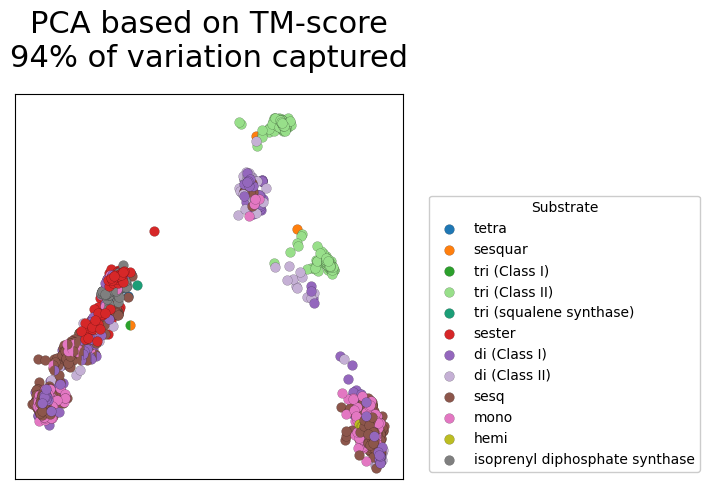

In [25]:
plot(all_ids_list, pca_coord_dom, f'PCA based on TM-score\n{sum(reducer_pca.explained_variance_ratio_)*100:.0f}% of variation captured', 'pca_tmscore', 
     domain_order=domain_order, double_domain_ids=double_domain_ids,
     no_interm_names=False,
     color_double_domains_only=False,
     id_2_substrates_set=id_2_type_set, 
     jitter_param=0.005, legend_anchor=(1.05, 0.), dot_size=50, plot_size=(5, 5))

# Medoids

  0%|          | 0/18 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


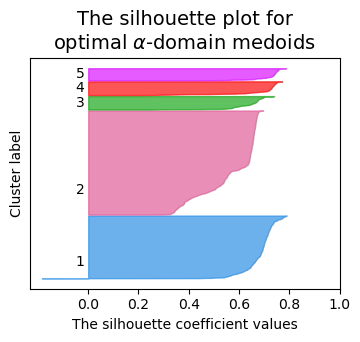

In [13]:
color_discrete_sequence=px.colors.qualitative.Dark24 + px.colors.qualitative.Light24 + px.colors.qualitative.Pastel1 + px.colors.qualitative.Pastel2 + px.colors.qualitative.Set3
silhouette_avg_all = []
distortions = []
max_silhouette_avg = -float('inf')
n_medoids_best = 1
rand_seed_best = None

for n_medoids in trange(2, 20):
    km_ = KMedoids(n_medoids, method='pam', metric='precomputed', init='k-medoids++', max_iter=1000)

    km_.fit(dist_mat)
    distortions.append(km_.inertia_)
    cluster_labels = km_.labels_
    silhouette_avg = silhouette_score(dist_mat, cluster_labels, metric='precomputed')
    if silhouette_avg > 0:
        sample_silhouette_values = silhouette_samples(dist_mat, cluster_labels, metric='precomputed')
        is_ok_each_cluster = True
        for i in range(n_medoids):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            repr_group_size = sum(cluster_labels == i)
        silhouette_avg_all.append(silhouette_avg)
        if is_ok_each_cluster and silhouette_avg > max_silhouette_avg:       
            max_silhouette_avg = silhouette_avg
            km = km_
            n_medoids_best = n_medoids
km = KMedoids(n_medoids_best, method='pam', metric='precomputed', max_iter=100000)
km.fit(dist_mat)
cluster_labels = km.labels_

sample_silhouette_values = silhouette_samples(dist_mat, cluster_labels, metric='precomputed')
silh_score_this = silhouette_score(dist_mat, cluster_labels, metric='precomputed')

_, ax = plt.subplots(figsize=(4, 3))
y_lower = 10
for i in range(n_medoids_best):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = color_discrete_sequence[i % n_medoids_best]
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    ax.text(-0.05, y_lower + 0.2 * size_cluster_i, str(i + 1))

    y_lower = y_upper + 10 

ax.set_title("The silhouette plot for\noptimal $\\alpha$-domain medoids", fontsize=14)
ax.set_xlabel("The silhouette coefficient values", fontsize=10)
ax.set_ylabel("Cluster label", fontsize=10)
ax.set_yticks([]) 
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

medoid_orig_indices = km.medoid_indices_
plt.savefig('silhouette_a.eps', bbox_inches='tight')

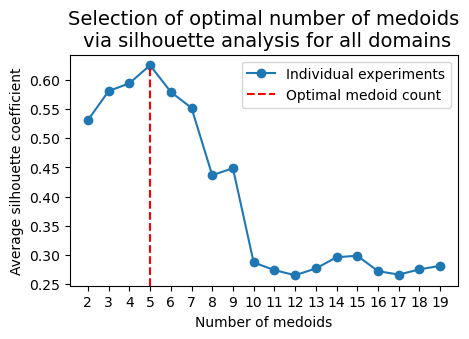

In [14]:
_, ax = plt.subplots(figsize=(5, 3))

plt.plot(range(2, 20), silhouette_avg_all, marker='o')

ax.axvline(x=5, ymax=0.95, color="red", linestyle="--")

ax.set_title("Selection of optimal number of medoids\n via silhouette analysis for all domains", fontsize=14)
ax.set_xlabel("Number of medoids", fontsize=10)
ax.set_ylabel("Average silhouette coefficient", fontsize=10)
ax.set_xticks(list(range(2, 20)))
ax.legend(['Individual experiments', 'Optimal medoid count'])

plt.savefig('silhouette_analysis_all.pdf', bbox_inches='tight', dpi=300)

In [15]:
km = KMedoids(5, method='pam', metric='precomputed', max_iter=10000, init='k-medoids++')
km.fit(dist_mat)
cluster_labels = km.labels_
medoid_orig_indices = km.medoid_indices_

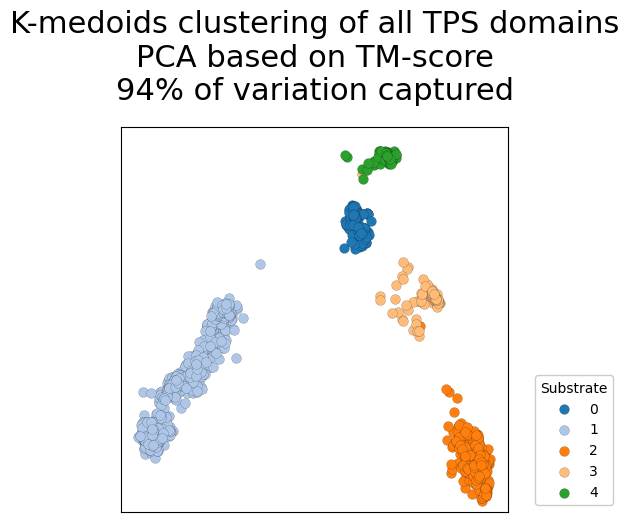

In [27]:
cmap = matplotlib.colormaps["tab20"]
colors = cmap(np.linspace(0, 1, 20))
reaction_class_2_color = {class_name: colors[i] for i, class_name in enumerate([str(i) for i in set(km.labels_)])}

plot(all_ids_list, pca_coord_dom, f'K-medoids clustering of all TPS domains\nPCA based on TM-score\n{sum(reducer_pca.explained_variance_ratio_)*100:.0f}% of variation captured', 'k_medoids_pca', 
     domain_order=domain_order, double_domain_ids=double_domain_ids,
     no_interm_names=False,
     color_double_domains_only=False,
     id_2_substrates_set=id_2_type_set, 
     reaction_class_2_color=reaction_class_2_color,
     point_labels=[str(i) for i in km.labels_], classes_order=[str(i) for i in sorted(set(km.labels_))],
     jitter_param=0.00, legend_anchor=(1.05, 0.), dot_size=50, plot_size=(5, 5)) 
plt.savefig('medoids_all.pdf', bbox_inches='tight')

In [17]:
medoid_2_regions = defaultdict(set)

for medoid_id, module_id in zip(km.labels_, [region.module_id for _, region in regions]):
    medoid_2_regions[medoid_id].add(module_id)

In [18]:
medoid_2_domains = defaultdict(list)
for medoid_id, module_id in zip(km.labels_, [region.domain for _, region in regions]):
    medoid_2_domains[medoid_id].append(module_id)
    
{medoid: Counter(vals) for medoid, vals in medoid_2_domains.items()}

{1: Counter({'alpha': 1079}),
 2: Counter({'beta': 649, 'delta': 1}),
 3: Counter({'delta': 142, 'beta': 1}),
 0: Counter({'gamma': 140}),
 4: Counter({'epsilon': 126})}

In [19]:
with open('data/tps_domains_and_comparisons/medoid_2_regions.pkl', 'wb') as file:
    pickle.dump(medoid_2_regions, file)

# HDBSCAN clustering

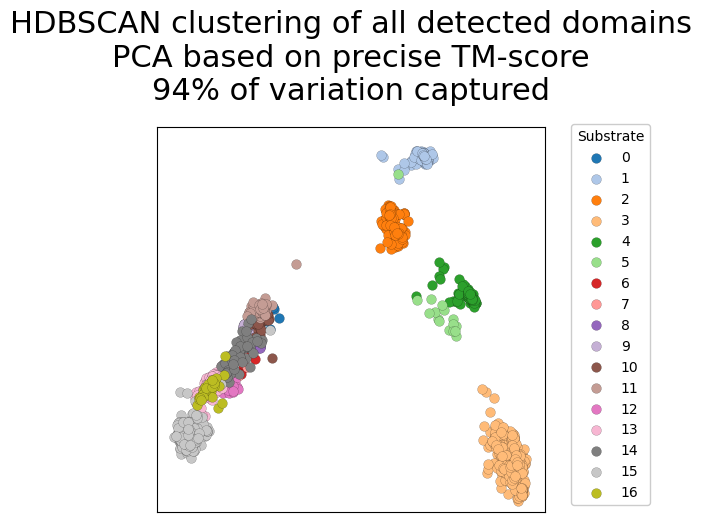

In [22]:
hdbscan_clusterer = hdbscan.HDBSCAN(metric='precomputed')
hdbscan_clusterer.fit(dist_mat)

def fill_noise_with_closest_label(labels_, dist_mat, n_neighbs=3):
    for i, val in enumerate(labels_):
        if labels_[i] == -1:
            label_counts = defaultdict(int)
            neighbours = np.argsort(dist_mat[i, :])[:n_neighbs]
            for neighb_i in neighbours:
                if labels_[neighb_i] != -1:
                    label_counts[labels_[neighb_i]] += 1
            labels_[i] = max(label_counts.items(), key=lambda el: el[1])[0]
                    
fill_noise_with_closest_label(hdbscan_clusterer.labels_, dist_mat)
reaction_class_2_color = {class_name: colors[i] for i, class_name in enumerate([str(i) for i in set(hdbscan_clusterer.labels_)])}

plot(all_ids_list, pca_coord_dom, f'HDBSCAN clustering of all detected domains\nPCA based on precise TM-score\n{sum(reducer_pca.explained_variance_ratio_)*100:.0f}% of variation captured', 'k_medoids_pca', 
     domain_order=domain_order, double_domain_ids=double_domain_ids,
     no_interm_names=False,
     color_double_domains_only=False,
     id_2_substrates_set=id_2_type_set, 
     reaction_class_2_color=reaction_class_2_color,
     point_labels=[str(i) for i in hdbscan_clusterer.labels_], classes_order=[str(i) for i in sorted(set(hdbscan_clusterer.labels_))],
     jitter_param=0.00, legend_anchor=(1.05, 0.), dot_size=50, plot_size=(5, 5)) 
plt.savefig('medoids_all.pdf', bbox_inches='tight')

# Separate $\alpha$ domains analysis

In [56]:
hdbscan_tree = hdbscan_clusterer.condensed_tree_.to_pandas()

In [57]:
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=40):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

pink_cmap = truncate_colormap(cm.get_cmap("BrBG", 80), 0, 0.5)
pink_cmap = cm.get_cmap("PiYG", 80) 
brown_cmap = cm.get_cmap("PuOr", 120) 

In [58]:
for alpha_type_i in range(4):
    type_bool_idx = km.labels_ == alpha_type_i
    subtype_vals = set(hdbscan_clusterer.labels_[type_bool_idx])
    for subtype in subtype_vals:
        if subtype != -1:
            alpha_type = i_2_name[alpha_type_i]
            print(f'Alpha{alpha_type}-{subtype}, inside alpha type #: {sum(np.logical_and(type_bool_idx, hdbscan_clusterer.labels_ == subtype))}, outside #: { {sum(np.logical_and(np.logical_not(type_bool_idx), hdbscan_clusterer.labels_ == subtype))}}')
            
    print('='*20)

Alpha4-0, inside alpha type #: 9, outside #: {0}
Alpha4-1, inside alpha type #: 11, outside #: {0}
Alpha4-2, inside alpha type #: 18, outside #: {0}
Alpha4-6, inside alpha type #: 16, outside #: {0}
Alpha4-8, inside alpha type #: 1, outside #: {35}
Alpha4-9, inside alpha type #: 150, outside #: {2}
Alpha4-10, inside alpha type #: 65, outside #: {0}
Alpha2-3, inside alpha type #: 26, outside #: {0}
Alpha2-4, inside alpha type #: 32, outside #: {0}
Alpha3-8, inside alpha type #: 35, outside #: {1}
Alpha3-9, inside alpha type #: 1, outside #: {151}
Alpha3-5, inside alpha type #: 32, outside #: {0}
Alpha3-7, inside alpha type #: 86, outside #: {0}
Alpha1-9, inside alpha type #: 1, outside #: {151}
Alpha1-11, inside alpha type #: 613, outside #: {0}
Alpha1-12, inside alpha type #: 41, outside #: {0}


In [68]:
alpha_type_subtype_2_module_ids = dict()
for alpha_type_i in range(4):
    type_bool_idx = km.labels_ == alpha_type_i
    subtype_vals = set(hdbscan_clusterer.labels_[type_bool_idx])
    type_i = 0
    for subtype in subtype_vals:
        if subtype != -1:
            inside_count = sum(np.logical_and(type_bool_idx, hdbscan_clusterer.labels_ == subtype))
            if inside_count > 2:
                alpha_type = i_2_name[alpha_type_i]
                print(f"Alpha{alpha_type}-{['A', 'B', 'C', 'D', 'E', 'F'][type_i]}, inside alpha type #: {inside_count}, outside #: { {sum(np.logical_and(np.logical_not(type_bool_idx), hdbscan_clusterer.labels_ == subtype))}}")
                alpha_type_subtype_2_module_ids[(alpha_type, ['A', 'B', 'C', 'D', 'E', 'F'][type_i])] = {region.module_id for i, (_, region) in enumerate(regions) if hdbscan_clusterer.labels_[i] == subtype}
                type_i += 1
    print('='*20)

Alpha4-A, inside alpha type #: 85, outside #: {0}
Alpha4-B, inside alpha type #: 32, outside #: {0}
Alpha4-C, inside alpha type #: 36, outside #: {1}
Alpha2-A, inside alpha type #: 9, outside #: {0}
Alpha2-B, inside alpha type #: 11, outside #: {0}
Alpha2-C, inside alpha type #: 18, outside #: {0}
Alpha2-D, inside alpha type #: 16, outside #: {0}
Alpha2-E, inside alpha type #: 148, outside #: {1}
Alpha2-F, inside alpha type #: 64, outside #: {0}
Alpha3-A, inside alpha type #: 24, outside #: {0}
Alpha3-B, inside alpha type #: 32, outside #: {0}
Alpha1-A, inside alpha type #: 610, outside #: {0}
Alpha1-B, inside alpha type #: 40, outside #: {0}


In [69]:
with open('data/alpha_type_subtype_2_module_ids.pkl', 'wb') as f:
    pickle.dump(alpha_type_subtype_2_module_ids, f)

In [29]:
def get_color_range_i(tmscore_diff, n_bins=25, max_tmscore_diff=0.4, reverse=False):
    delta = max_tmscore_diff/n_bins
    result = int(n_bins - tmscore_diff // delta)
    if reverse:
        return n_bins - result
    return result  + 10

medoid_cmaps = [pink_cmap, brown_cmap, cm.get_cmap("Greys", 40), cm.get_cmap("Greens", 40) ] #cm.get_cmap("Oranges", 40), 
reverse_cmaps = [True, True, False, False]
    
def plot_medoids_zones(distmatrix, medoid_orig_indices, max_tmscore_diff, all_ids_list, regions_list, coord, title_str, file_name, 
         is_jittered=True, jitter_param=0.005, dot_size=22, legend_anchor=(.3005, 0.),
        no_interm_names=False, plot_size=(10, 10), legend_title='TPS Type', categories_to_show=None, hide_legend=False):

    coords = [jitter(coord[:, 0], jitter_param), jitter(coord[:, 1], jitter_param)]if is_jittered else [coord[:, 0], coord[:, 1]]
    _, ax = plt.subplots(1, 1, figsize=plot_size)

    class_2_x = defaultdict(list)
    class_2_y = defaultdict(list)
    single_substr_classes = set()
    double_substr_classes = set()
    all_observed_substr_classes = set()
    x_min, x_max = float('inf'), -float('inf')
    y_min, y_max = float('inf'), -float('inf')
  
    main_medoid_2_ids = defaultdict(list)
    medoids_all = []
    for inst_i, uni_id in enumerate(all_ids_list):
        x, y = coords[0][inst_i], coords[1][inst_i]
        instance_labels = []
        instance_label_dists = []
        for medoid_i, medoid_inst_i in enumerate(medoid_orig_indices):
            dist_to_medoid = distmatrix[medoid_inst_i, inst_i]
            if dist_to_medoid < max_tmscore_diff:
                instance_label_dists.append(dist_to_medoid)
                instance_labels.append(medoid_i)
            
        if len(instance_labels) == 1:
            medoid_i = instance_labels[0]
            class_name = medoid_cmaps[medoid_i](get_color_range_i(instance_label_dists[0], reverse=reverse_cmaps[medoid_i]))
            class_2_x[class_name].append(x)
            class_2_y[class_name].append(y)
            single_substr_classes.add(class_name)
            main_medoid_2_ids[medoid_i].append(regions_list[inst_i])
            medoids_all.append(medoid_i)
        elif len(instance_labels) > 1:
            largest_pair_indices = sorted(list(range(len(instance_label_dists))), key=lambda i: instance_label_dists[i])[:2]
            largest_pair = [instance_labels[i] for i in largest_pair_indices]
            
            colors = []
            for i in largest_pair_indices:
                medoid_i = instance_labels[i]    
                colors.append(medoid_cmaps[medoid_i](get_color_range_i(instance_label_dists[i], reverse=reverse_cmaps[medoid_i])))
                medoids_all.append(medoid_i)
            class_name = tuple(colors)
            double_substr_classes.add(class_name)
            class_2_x[class_name].append(x)
            class_2_y[class_name].append(y)
            main_medoid_2_ids[instance_labels[largest_pair_indices[0]]].append(regions_list[inst_i])
        else:
            class_2_x['bg'].append(x)
            class_2_y['bg'].append(y)
        x_min = min(x, x_min)
        x_max = max(x, x_max)
        y_min = min(y, y_min)
        y_max = max(y, y_max)
        
    print(Counter(medoids_all))
    
    df = pd.DataFrame({"x": class_2_x['bg'], 'y': class_2_y['bg']})
    ax.scatter(df['x'], df['y'], s=dot_size, color='gray', linewidths=0.2, marker=MarkerStyle("o", fillstyle="none"))
    
    for double_substr_class in sorted(double_substr_classes, reverse=True):
        df = pd.DataFrame({"x": class_2_x[double_substr_class], 
                           'y': class_2_y[double_substr_class]})
        ax.scatter(df['x'], df['y'], s=dot_size, color=double_substr_class[1], linewidths=1.5, marker=MarkerStyle("o", fillstyle="right"))
        ax.scatter(df['x'], df['y'], s=dot_size, color=double_substr_class[0], linewidths=1.5, marker=MarkerStyle("o", fillstyle="left"))
    for substr_class in sorted(single_substr_classes, reverse=True):
        df = pd.DataFrame({"x": class_2_x[substr_class], 
                           'y': class_2_y[substr_class]})
        ax.scatter(df['x'], df['y'], s=dot_size, color=substr_class, linewidths=1.5, marker=MarkerStyle("o", fillstyle="full"))
        
    legend_handles = []
    
    missing_classes = set()
    for medoid_i, medoid_cmap in enumerate(medoid_cmaps):
        df = pd.DataFrame({"x": [x_max*2], 
                               'y': [y_max*2]})
        legend_handles.append(ax.scatter(df['x'], df['y'], s=dot_size, color=medoid_cmap(get_color_range_i(0.1)), marker="o"))

        
    if not hide_legend:       
        legend = ax.legend(legend_handles, range(len(medoid_cmaps)), loc="lower left", 
                           title="Substrate", 
                                bbox_to_anchor=legend_anchor, 
                                ncol=1)
        legend.get_frame().set_alpha(None)
        legend.get_frame().set_facecolor((1, 1, 1, 1))
    ax.set_xticks([])
    ax.set_yticks([])
    print((x_min, x_max))
    ax.set_xlim((x_min-np.abs(x_min)/10, x_max-np.abs(x_max)/20))
    ax.set_ylim((y_min-np.abs(y_min)/10, y_max+np.abs(y_max)/10))
    return main_medoid_2_ids

#     plt.title(title_str, fontsize=22, y=1.05)
    
for thresh in [0.1, 0.2, 0.3, 0.4]:
    main_medoid_2_ids = plot_medoids_zones(dist_mat, medoid_orig_indices, thresh,
         all_ids_list, regions, pca_coord_dom, f'PCA based on $\\alpha$ domains', '_temp_b_g_medoids',

         jitter_param=0.00, legend_anchor=(0.15, 0.), dot_size=50, plot_size=(4, 4), hide_legend=True) #, categories_to_show=['sester', 'polyprenyl synthetase'])

    plt.scatter(pca_coord_dom[km.medoid_indices_, 0], pca_coord_dom[km.medoid_indices_, 1], s=100, 
                c=[medoid_cmap(get_color_range_i(0.1, reverse=reverse_cmaps[medoid_i])) for medoid_i, medoid_cmap in enumerate(medoid_cmaps)], linewidths=2, edgecolors='black', marker='X')
#     plt.title(f'TM-score {thresh}', fontsize=14, y=1.05)
    plt.savefig(f'a_medoids_0{thresh*100}.eps')

Counter({3: 1103, 1: 939, 0: 155, 2: 57})
(-3.0399777363266556, 6.407242818685622)


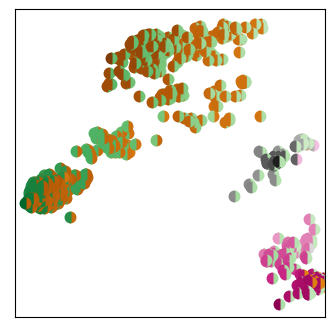

In [38]:
main_medoid_2_ids = plot_medoids_zones(dist_mat, medoid_orig_indices, 0.5,
         all_ids_list, regions, pca_coord_dom, f'PCA based on $\\alpha$ domains', '_temp_b_g_medoids',

         jitter_param=0.00, legend_anchor=(0.15, 0.), dot_size=50, plot_size=(4, 4), hide_legend=True) #, categories_to_show=['sester', 'polyprenyl synthetase'])

id_2_medoid = dict()
for medoid, ids in main_medoid_2_ids.items():
    for uni_id, _ in ids:
        id_2_medoid[uni_id] = medoid
point_medoid_ids = [id_2_medoid[i] for i in all_ids_list]
